# Blocklist Statistical Signifiance

This notebook analyzes the DALL-E-2 blocklist experiments to determine the statistical significance probed.

In [5]:
import sys
sys.path.append('../')
sys.path.append('../../')

from db import *
from analysis import *

# Data

In [6]:
median_response_time = func.percentile_cont(0.5).within_group(
    ImageCreationRequest.response_time.asc()
).label('median_response_time')

data = (
    session.query(
        median_response_time,
        Prompts.dataset,
        Prompts.prompt,
    ).join(
        Prompts, ImageCreationRequest.prompt_id == Prompts.id
    ).filter(
        or_(
            Prompts.dataset == 'blocklist',
            Prompts.dataset == 'blocklist_mutate',
        )
    ).group_by(
        ImageCreationRequest.prompt_id, Prompts.dataset, Prompts.prompt
    )
)
df = query_to_df(data)
print(len(df))
df.head()

50


,median_response_time,dataset,prompt
0,0.183459,blocklist,None
1,0.512995,blocklist_mutate,None
2,0.184361,blocklist,None
3,0.523655,blocklist_mutate,None
4,0.201148,blocklist,None


# Statistical Test

In [7]:
from scipy.stats import ttest_ind

blocklist = df[df['dataset'] == 'blocklist']['median_response_time']
blocklist_mutate = df[df['dataset'] == 'blocklist_mutate']['median_response_time']

# Perform a one-tailed t-test (e.g., testing if blocklist_mutate has higher response times than blocklist)
t_stat_one_tailed, p_value_one_tailed = ttest_ind(blocklist, blocklist_mutate, equal_var=False, alternative='two-sided')

# p < 0.01
print(f'{t_stat_one_tailed=}')
print(f'{p_value_one_tailed=}')
print(f'{(p_value_one_tailed < 0.0001)=}')


t_stat_one_tailed=np.float64(-8.314856714177656)
p_value_one_tailed=np.float64(1.5095244491319058e-08)
(p_value_one_tailed < 0.0001)=np.True_


# Graph

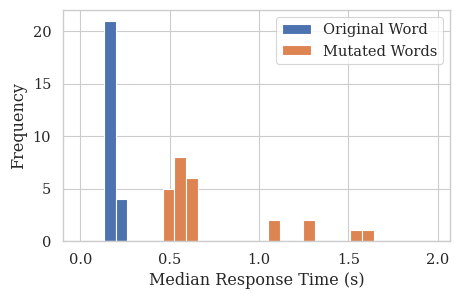

In [8]:
blocklist = df[df['dataset'] == 'blocklist']
blocklist_mutate = df[df['dataset'] == 'blocklist_mutate']

# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(5, 3))

plt_range = (0, df['median_response_time'].max() *1.25)

ax.hist(blocklist['median_response_time'], range=plt_range, color=palette[0], label="Original Word", bins=30)
ax.hist(blocklist_mutate['median_response_time'], range=plt_range, color=palette[1], label="Mutated Words", bins=30)

ax.legend()

ax.set_ylabel('Frequency')
ax.set_xlabel('Median Response Time (s)')

# plt.savefig('figures/dalle_2_blocklist.pdf', bbox_inches='tight')
plt.show()